# Studying artists' career to understand the patterns and their determinants

In [37]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import unicodedata
import sklearn.cluster as cluster
from sklearn.decomposition import PCA
from collections import defaultdict
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as pe
# %matplotlib inline

In [38]:
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)
global color_h, color_f, color_b, PLOTDIM, FREQYEARS
color_h = "gold"
color_f = "royalblue"
color_b = "lightgray"
PLOTDIM = (9,6)
FREQYEARS = 10
my_cm = LinearSegmentedColormap.from_list("colormap", [color_h, color_f], N=100)

In [39]:
matplotlib.font_manager._rebuild()
plt.rcParams['font.family'] = 'Roboto'
plt.rcParams['font.sans-serif'] = 'Roboto'
plt.rcParams['font.weight'] = 500
# matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [40]:
def linearize(str1):
    d = [str1[0]] + [str1[i] for i in range(1,len(str1)) if str1[i-1] != str1[i]]
    return ''.join(d)

#### Import data

In [41]:
raw_authors = pd.read_csv('../data/ALL_AUTHORS (live_work + clean nat).csv', encoding='utf-8', sep=',', low_memory=False)
raw_art = pd.read_csv('../data/ALL_ARTWORKS (for stats use ONLY).csv', encoding='utf-8', sep=',', low_memory=False)
raw_art['groupcol'] = raw_art['related'].fillna(value='') + raw_art['acquisition'].fillna(value='')

In [42]:
# On travaille en points de contact
art = raw_art.groupby(['authors', 'collection', 'acquisition_year']).first().reset_index()
art = art[art['acquisition_year'] > 1945]
raw_authors['live_and_work'] = raw_authors['live_and_work'].replace({'0': None})
print(art.shape, raw_authors.shape)

(71660, 117) (35958, 23)


In [ ]:
# raw_authors.columns

In [ ]:
museums = pd.read_csv('../data/MUSEUMS_AND_VISITORS.csv', encoding='utf-8', sep=',', low_memory=False)

In [ ]:
art[art.collection.str.contains("Fonds municipal d'art contemporain")]

#### Encode collections into broader categories

In [ ]:
art = art[pd.notnull(art['collection'])]
art['collection_category'] = None
for i, row in art.iterrows():
    museum = row['collection']
    if "frac" in museum.lower():
        cat = 'F'
    elif "musée national d'art moderne" in museum.lower():
        cat = 'P'
    elif "centre national des arts plastiques" in museum.lower():
        cat = 'C'
    elif "musée" in museum.lower():
        cat = 'M'
    else:
        cat = 'A'
    art.at[i, 'collection_category'] = cat

In [ ]:
art['collection_category'].value_counts()

In [ ]:
art[art['collection_category'] == 'F']['collection'].value_counts()

In [ ]:
def compute_acquisition_year(row):
    ind = row['Id artist']
    a = art[art['authors'].str.contains(str(ind))].sort_values('acquisition_year')
    return '|'.join([str(int(x)) for x in a['acquisition_year'].values])

In [ ]:
def compute_sequence(row):
    ind = str(row['Id artist'])
    a = art[art['authors'].str.contains(str(ind))].sort_values('acquisition_year')
    print(ind)
    return ''.join([x for x in a['collection_category'].values])

In [ ]:
def compute_art_count(row):
    dates = row['acquisition_year']
    if not pd.isnull(dates):
        dates = [int(d) for d in re.split('\|', dates)]
        return len(dates)

In [ ]:
def compute_first_acquisition(row):
    dates = row['acquisition_year']
    if not pd.isnull(dates):
        dates = [int(d) for d in re.split('\|', dates)]
        return min(dates)

In [ ]:
def compute_last_aquisition_alive(row):
    dates = row['acquisition_year']
    if not pd.isnull(dates):
        dates = [int(d) for d in re.split('\|', dates)]
        if not pd.isnull(row['Death year']):
            dates = [d for d in dates if d <= row['Death year']]
        if len(dates) > 0:
            raw_authors.at[i, 'last_aquisition_alive'] = max(dates)

In [ ]:
raw_authors['acquisition_year'] = raw_authors.apply(compute_acquisition_year, axis=1).replace({'': None})

In [ ]:
raw_authors['sequence'] = raw_authors.apply(compute_sequence, axis=1)

In [ ]:
raw_authors['art_count'] = raw_authors.apply(compute_art_count, axis=1)

In [ ]:
raw_authors['first_aquisition'] = raw_authors.apply(compute_first_acquisition, axis=1)

In [ ]:
raw_authors['last_aquisition_alive'] = raw_authors.apply(compute_last_aquisition_alive, axis=1)

In [ ]:
raw_authors['first_aquisition'].value_counts()

<h2 style="color:red"> Règle utilisée : plus de 4 acquisitions et mort ou semi-mort (2870 individus)</h2>

In [ ]:
authors = raw_authors[raw_authors['art_count'] >= 4]
authors = authors[authors['first_aquisition'] >= 1945]

In [ ]:
for i, row in authors.iterrows():
    if pd.isnull(row['last_aquisition_alive']):
        authors.at[i, 'dead_career'] = 0
    elif (2018 - row['Birth year'] > 65) and (row['last_aquisition_alive'] < 2000):
        authors.at[i, 'dead_career'] = 1
    else:
        authors.at[i, 'dead_career'] = 2

In [ ]:
# Count of alive but dead career artists
x = ((authors['dead_career'] == 1) & pd.isnull(authors['Death year'])).sum()
authors = authors[pd.notnull(authors['Death year']) | (authors['dead_career'] == 1)]
print("Total number of artists: ", len(authors))
print("Including number of dead-career artists: ", x)

In [ ]:
(authors['Death year'] - authors['Birth year']).mean()

Save newly created dataframe

In [10]:
#authors.to_csv("../data/DEAD AUTHORS (broadly).csv", encoding='utf-8', sep=',')
authors = pd.read_csv("../data/DEAD AUTHORS (broadly).csv", encoding='utf-8', sep=',')

In [11]:
len(authors)

6705

In [12]:
authors['variété'] = authors['sequence'].apply(set).apply(len)
authors['retournements'] = authors['sequence'].apply(linearize).apply(len).apply(lambda x: x-1)

In [13]:
len(authors), sum(authors['Gender'] == 'masculin'), sum(authors['Gender'] == 'féminin')

(6705, 5755, 939)

In [14]:
def groupate(str1):
    if len(str1) < 3: return 'P'
    elif len(str1) < 6: return 'M'
    else: return 'G'

In [15]:
authors['Group'] = authors['sequence'].apply(groupate)
print(authors['Group'].value_counts())
print(authors[authors['Gender'] == 'masculin']['Group'].value_counts())
print(authors[authors['Gender'] == 'féminin']['Group'].value_counts())

P    3835
G    1535
M    1335
Name: Group, dtype: int64
P    3271
G    1330
M    1154
Name: Group, dtype: int64
P    553
G    205
M    181
Name: Group, dtype: int64


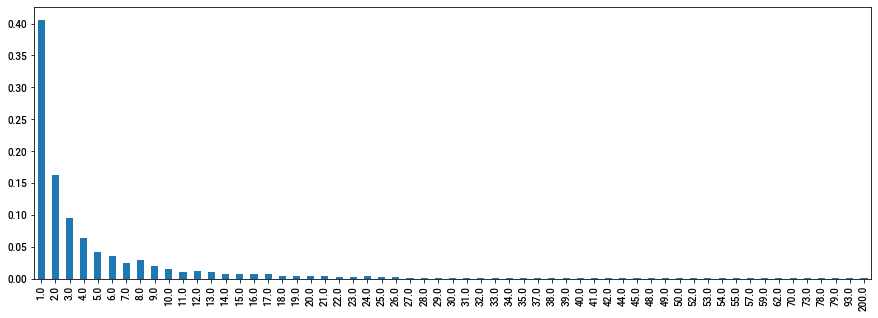

In [16]:
authors[authors['Gender'] == 'masculin']['art_count'].value_counts(True).sort_index().plot(kind='bar', figsize=(15,5))

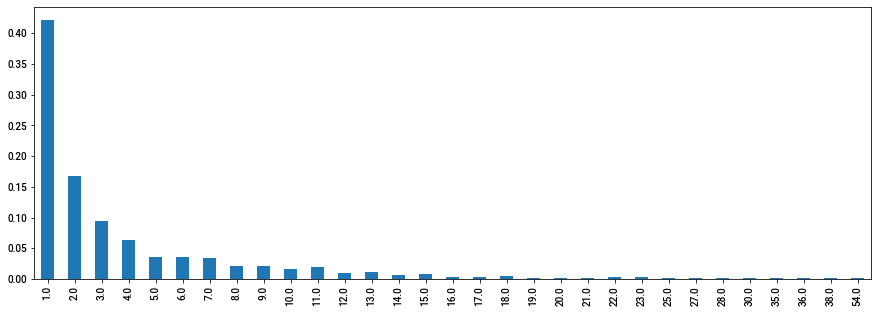

In [17]:
authors[authors['Gender'] == 'féminin']['art_count'].value_counts(True).sort_index().plot(kind='bar', figsize=(15,5))

Number of artworks per author in our dataset

In [18]:
# authors = authors[authors['art_count'] >= 4]

In [19]:
# Variété (nombre de lettres différentes dans la séquence) -- Hommes
print(authors[(authors['Gender'] == 'masculin') & (authors['Group'] == 'M')]['variété'].value_counts().sort_index())
print(authors[(authors['Gender'] == 'masculin') & (authors['Group'] == 'G')]['variété'].value_counts().sort_index())

1    330
2    610
3    199
4     15
Name: variété, dtype: int64
1     80
2    389
3    465
4    320
5     76
Name: variété, dtype: int64


In [20]:
# Variété -- Femmes
print(authors[(authors['Gender'] == 'féminin') & (authors['Group'] == 'M')]['variété'].value_counts().sort_index())
print(authors[(authors['Gender'] == 'féminin') & (authors['Group'] == 'G')]['variété'].value_counts().sort_index())

1     48
2    100
3     32
4      1
Name: variété, dtype: int64
1     5
2    67
3    78
4    52
5     3
Name: variété, dtype: int64


In [21]:
# Retournements (dédoublement des lettres - 1) -- Hommes
print(authors[(authors['Gender'] == 'masculin') & (authors['Group'] == 'M')]['retournements'].value_counts().sort_index())
print(authors[(authors['Gender'] == 'masculin') & (authors['Group'] == 'G')]['retournements'].value_counts().sort_index())

0    330
1    364
2    317
3    120
4     23
Name: retournements, dtype: int64
0      80
1      61
2     113
3     151
4     170
5     141
6      95
7      72
8      63
9      53
10     46
11     50
12     28
13     29
14     26
15     22
16     20
17     12
18     15
19     12
20      8
21     10
22      2
23      3
24      4
25      4
26      5
27      2
28      3
29      5
30      4
31      5
33      1
34      1
35      1
36      1
37      1
38      3
40      1
41      1
43      1
45      1
46      1
54      1
57      1
66      1
Name: retournements, dtype: int64


In [22]:
# Retournements (dédoublement des lettres - 1) -- Femmes
print(authors[(authors['Gender'] == 'féminin') & (authors['Group'] == 'M')]['retournements'].value_counts().sort_index())
print(authors[(authors['Gender'] == 'féminin') & (authors['Group'] == 'G')]['retournements'].value_counts().sort_index())

0    48
1    53
2    61
3    16
4     3
Name: retournements, dtype: int64
0      5
1     11
2     18
3     28
4     30
5     24
6     22
7     12
8     14
9     12
10     5
11     2
12     4
13     4
14     3
15     3
16     2
18     1
19     1
20     1
21     1
27     1
40     1
Name: retournements, dtype: int64


In [23]:
# Retournements : valeurs aggrégées, moyenne
authors.groupby(['Gender', 'variété'])['retournements'].mean().sort_index()

Gender         variété
féminin        1           0.000000
               2           1.940426
               3           5.236364
               4           9.075472
               5          11.000000
masculin       1           0.000000
               2           2.047826
               3           5.786145
               4          10.185075
               5          18.657895
non renseigné  1           0.000000
Name: retournements, dtype: float64

In [24]:
# Retournements : valeurs aggrégées, variance
authors.groupby(['Gender', 'variété'])['retournements'].count().sort_index()

Gender         variété
féminin        1           538
               2           235
               3           110
               4            53
               5             3
masculin       1          3300
               2          1380
               3           664
               4           335
               5            76
non renseigné  1            11
Name: retournements, dtype: int64

In [25]:
def attente_cum(str1):
    x = str1.split('|')
    res = ''
    tmp = None
    for i, y in enumerate(x):
        if i == 0:
            tmp = y
        else:
            res += '|' + str(int(y) - int(tmp))
    return res[1:]

In [26]:
def attente(str1):
    x = str1.split('|')
    res = ''
    tmp = None
    for i, y in enumerate(x):
        if i == 0:
            tmp = y
        else:
            res += '|' + str(int(y) - int(tmp))
            tmp = y
    return res[1:]

In [27]:
authors['attente'] = authors['acquisition_year'].apply(attente)
authors['attente_cum'] = authors['acquisition_year'].apply(attente_cum)

In [28]:
moy_att_h, moy_att_f = [], []
moy_cum_h, moy_cum_f = [], []
for i in range(14):
    somme_h, somme_f = [], []
    cum_h, cum_f = [], []
    for k, x in authors[authors['art_count'] > 1].iterrows():
        y = x['attente'].split('|')
        z = x['attente_cum'].split('|')
        if len(y) < i+1:
            pass
        else:
            if x['Gender'] == 'masculin':
                somme_h.append(int(y[i]))
                cum_h.append(int(z[i]))
            elif x['Gender'] == 'féminin':
                somme_f.append(int(y[i]))
                cum_f.append(int(z[i]))
    moy_att_h.append(sum(somme_h)/len(somme_h))
    moy_att_f.append(sum(somme_f)/len(somme_f))
    moy_cum_h.append(sum(cum_h)/len(cum_h))
    moy_cum_f.append(sum(cum_f)/len(cum_f))

In [29]:
len(moy_att_h), len(range(2,17))

(14, 15)

In [30]:
fig, ax = plt.subplots()
ratio2 = pd.Series(moy_att_h, index=[i for i in range(2,16)])
ratio = pd.Series(moy_att_f, index=[i for i in range(2,16)])
ratio.plot(figsize=PLOTDIM, color=color_f, marker='.', linewidth=2, ax=ax)
ratio2.plot(figsize=PLOTDIM, color=color_h, marker='.', linewidth=2, ax=ax)
ax.set_xlim(left = 1.5,right = 15.5)
ax.set_ylim(bottom = 0.0,top = 6.51)
ax.tick_params(labelsize = 15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xlabel('')
# ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
plt.grid()
plt.savefig("Attente.png", bbox_inches='tight',format="png", dpi=300, transparent=True)
plt.close()

In [31]:
fig, ax = plt.subplots()
ratio2 = pd.Series(moy_cum_h, index=[i for i in range(2,16)])
ratio = pd.Series(moy_cum_f, index=[i for i in range(2,16)])
ratio.plot(figsize=PLOTDIM, color=color_f, marker='.', linewidth=2, ax=ax)
ratio2.plot(figsize=PLOTDIM, color=color_h, marker='.', linewidth=2, ax=ax)
ax.set_xlim(left = 1.5,right = 15.5)
ax.set_ylim(bottom = 0.0,top = 27.51)
ax.tick_params(labelsize = 15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xlabel('')
# ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
plt.grid()
plt.savefig("Attente_cum.png", bbox_inches='tight',format="png", dpi=300, transparent=True)
plt.close()

### Temps d'attente sans don et avant don, et après don

In [71]:
cat_dons = ['Dons', 'Dation', 'Donation', 'Legs']
cat_achats = ['Achat', 'Commande']

#### Encodage des types d'acquisitions

In [72]:
def classify_type(string):
    if string in cat_dons: return 'D'
    elif string in cat_achats: return 'A'
    else: return 'E'

In [166]:
def compute_acquisition_types(row):
    ind = row['Id artist']
    a = art[art['authors'].str.contains(str(round(ind)))].sort_values('acquisition_year')
    return ''.join([classify_type(x) for x in a['acquisition_mode_clean'].values])

In [167]:
authors['sequence_acqutypes'] = authors.apply(compute_acquisition_types, axis=1)

#### Calcul des temps d'attente : V1 avec donateur/non donateur

In [168]:
moy_att_ad_h, moy_att_nd_h, moy_att_ad_f, moy_att_nd_f = [], [], [], []
moy_cum_ad_h, moy_cum_nd_h, moy_cum_ad_f, moy_cum_nd_f = [], [], [], []
for i in range(14):
    somme_ad_h, somme_nd_h, somme_ad_f, somme_nd_f = [], [], [], []
    cum_ad_h, cum_nd_h, cum_ad_f, cum_nd_f = [], [], [], []
    for k, x in authors[authors['art_count'] > 1].iterrows():
        y = x['attente'].split('|')
        z = x['attente_cum'].split('|')
        if len(y) < i+1:
            pass
        else:
            # print(x['sequence_acqutypes'])
            if 'D' in x['sequence_acqutypes']:
                if x['Gender'] == 'masculin':
                    somme_ad_h.append(int(y[i]))
                    cum_ad_h.append(int(z[i]))
                elif x['Gender'] == 'féminin':
                    somme_ad_f.append(int(y[i]))
                    cum_ad_f.append(int(z[i]))
            else:
                if x['Gender'] == 'masculin':
                    somme_nd_h.append(int(y[i]))
                    cum_nd_h.append(int(z[i]))
                elif x['Gender'] == 'féminin':
                    somme_nd_f.append(int(y[i]))
                    cum_nd_f.append(int(z[i]))
    
    moy_att_ad_h.append(sum(somme_ad_h)/len(somme_ad_h))
    moy_att_nd_h.append(sum(somme_nd_h)/len(somme_nd_h))
    moy_cum_ad_h.append(sum(cum_ad_h)/len(cum_ad_h))
    moy_cum_nd_h.append(sum(cum_nd_h)/len(cum_nd_h))
    moy_att_ad_f.append(sum(somme_ad_f)/len(somme_ad_f))
    moy_att_nd_f.append(sum(somme_nd_f)/len(somme_nd_f))
    moy_cum_ad_f.append(sum(cum_ad_f)/len(cum_ad_f))
    moy_cum_nd_f.append(sum(cum_nd_f)/len(cum_nd_f))

In [169]:
fig, ax = plt.subplots()
ratio1 = pd.Series(moy_att_ad_h, index=[i for i in range(2,16)])
ratio2 = pd.Series(moy_att_ad_f, index=[i for i in range(2,16)])
ratio3 = pd.Series(moy_att_nd_h, index=[i for i in range(2,16)])
ratio4 = pd.Series(moy_att_nd_f, index=[i for i in range(2,16)])
ratio1.plot(figsize=PLOTDIM, color=color_f, marker='.', linewidth=2, ax=ax)
ratio2.plot(figsize=PLOTDIM, color='blue', marker='.', linewidth=2, ax=ax)
ratio3.plot(figsize=PLOTDIM, color=color_h, marker='.', linewidth=2, ax=ax)
ratio4.plot(figsize=PLOTDIM, color='yellow', marker='.', linewidth=2, ax=ax)
ax.set_xlim(left = 1.5,right = 15.5)
ax.set_ylim(bottom = 0.0,top = 7.51)
ax.tick_params(labelsize = 15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xlabel('')
# ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
plt.grid()
plt.savefig("Attente_donsoupas.png", bbox_inches='tight',format="png", dpi=300, transparent=True)
plt.close()

#### Découpage des carrières avant don/après don

In [170]:
authors['first_don'] = authors['sequence_acqutypes'].str.find('D')

In [252]:
res = []
for i, a in authors[authors['art_count'] > 1].iterrows():
    fd = int(a['first_don'])
    if fd == 0 or fd == -1:
        res.append({'Gender': a['Gender'],
                    'sequence_acqutypes': a['sequence_acqutypes'],
                    'attente': a['attente'],
                    'attente_cum': a['attente_cum'],
                    'original': a['sequence_acqutypes'],
                    'first_don': a['first_don'],
                    'case': 1
                   })
    else:
        A1 = {'Gender': a['Gender'],
                    'sequence_acqutypes': a['sequence_acqutypes'][:fd-1],
                    'attente': '|'.join(a['attente'].split('|')[:fd-1]),
                    'attente_cum': '|'.join(a['attente_cum'].split('|')[:fd-1]),
                    'original': a['sequence_acqutypes'],
                    'first_don': a['first_don'],
                    'case': 3
                   }
        A2 = {'Gender': a['Gender'],
                'sequence_acqutypes': a['sequence_acqutypes'][fd-1:],
                'attente': '|'.join(a['attente'].split('|')[fd-1:]),
                'attente_cum': '|'.join(a['attente_cum'].split('|')[fd-1:]),
                'original': a['sequence_acqutypes'],
                'first_don': a['first_don'],
                'case': 4
              }
        if not A1['attente'] == '': res.append(A1)
        if not A2['attente'] == '': res.append(A2)
authors_foratt = pd.DataFrame(res)

In [253]:
len(authors_foratt), len(authors[authors['art_count'] > 1])

(4457, 3961)

In [254]:
authors_foratt.loc[78]

Gender                                        masculin
sequence_acqutypes                              AAAEEE
attente                                    0|2|6|3|2|1
attente_cum                             0|2|8|11|13|14
original              AAAEEEEDAAADEAAAEEDAAEAEEEEEAEED
first_don                                            7
case                                                 3
Name: 78, dtype: object

#### Calcul des temps d'attente : V1 avec donateur/non donateur

In [256]:
moy_att_ad_h, moy_att_nd_h, moy_att_ad_f, moy_att_nd_f = [], [], [], []
moy_cum_ad_h, moy_cum_nd_h, moy_cum_ad_f, moy_cum_nd_f = [], [], [], []
for i in range(14):
    somme_ad_h, somme_nd_h, somme_ad_f, somme_nd_f = [], [], [], []
    cum_ad_h, cum_nd_h, cum_ad_f, cum_nd_f = [], [], [], []
    for k, x in authors_foratt.iterrows():
        y = x['attente'].split('|')
        z = x['attente_cum'].split('|')
        if len(y) < i+1:
            pass
        else:
            if 'D' in x['sequence_acqutypes']:
                if x['Gender'] == 'masculin':
                    somme_ad_h.append(int(y[i]))
                    cum_ad_h.append(int(z[i]))
                elif x['Gender'] == 'féminin':
                    somme_ad_f.append(int(y[i]))
                    cum_ad_f.append(int(z[i]))
            else:
                if x['Gender'] == 'masculin':
                    somme_nd_h.append(int(y[i]))
                    cum_nd_h.append(int(z[i]))
                elif x['Gender'] == 'féminin':
                    somme_nd_f.append(int(y[i]))
                    cum_nd_f.append(int(z[i]))
    
    moy_att_ad_h.append(sum(somme_ad_h)/len(somme_ad_h))
    moy_att_nd_h.append(sum(somme_nd_h)/len(somme_nd_h))
    moy_cum_ad_h.append(sum(cum_ad_h)/len(cum_ad_h))
    moy_cum_nd_h.append(sum(cum_nd_h)/len(cum_nd_h))
    moy_att_ad_f.append(sum(somme_ad_f)/len(somme_ad_f))
    moy_att_nd_f.append(sum(somme_nd_f)/len(somme_nd_f))
    moy_cum_ad_f.append(sum(cum_ad_f)/len(cum_ad_f))
    moy_cum_nd_f.append(sum(cum_nd_f)/len(cum_nd_f))

In [258]:
fig, ax = plt.subplots()
ratio1 = pd.Series(moy_att_ad_h, index=[i for i in range(2,16)])
ratio2 = pd.Series(moy_att_ad_f, index=[i for i in range(2,16)])
ratio3 = pd.Series(moy_att_nd_h, index=[i for i in range(2,16)])
ratio4 = pd.Series(moy_att_nd_f, index=[i for i in range(2,16)])
ratio1.plot(figsize=PLOTDIM, color=color_f, marker='.', linewidth=2, ax=ax)
ratio2.plot(figsize=PLOTDIM, color='blue', marker='.', linewidth=2, ax=ax)
ratio3.plot(figsize=PLOTDIM, color=color_h, marker='.', linewidth=2, ax=ax)
ratio4.plot(figsize=PLOTDIM, color='yellow', marker='.', linewidth=2, ax=ax)
ax.set_xlim(left = 1.5,right = 15.5)
ax.set_ylim(bottom = 0.0,top = 8.51)
ax.tick_params(labelsize = 15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xlabel('')
# ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
plt.grid()
plt.savefig("Attente_donsoupas_vVincent.png", bbox_inches='tight',format="png", dpi=300, transparent=True)
plt.close()

In [240]:
'|'.join(a['attente_cum'].split('|')[fd-1:])

'1|1|2|2|3|3|3|3|3|5|5|6|7|8|14|15|17|24'

## Acquisition paths distance and clustering

In [32]:
ARTISTS_SEQUENCES = dict()
nmod = 5
for i, row in authors.iterrows():
    ARTISTS_SEQUENCES[row['Id artist']] = row['sequence']
ARTISTS = list(ARTISTS_SEQUENCES.keys())

In [ ]:
# ICI POUR LE RANG DES LIGNES ET COLONNES
convert = {'C': 0, 'P': 1, 'F': 2, 'M': 3, 'A': 4}
ranking = {'C': 1, 'P': 1, 'F': 0.5, 'M': 0.1, 'A': 0.1}

#### Compute Markov Matrix

In [75]:
def compute_markov(art_sequences):
    markov = np.zeros((nmod, nmod))
    count = np.zeros(nmod)
    for artist in list(art_sequences.keys()):
        path = art_sequences[artist]
        for i in range(1, len(path)):
            markov[convert[path[i-1]], convert[path[i]]] += 1
            count[convert[path[i-1]]] += 1
    for i in range(nmod):
        if count[i] == 0:
            markov[i,i] = 1
            count[i] = 1
    markov = markov / count[:,None]
    return markov

In [76]:
markov = compute_markov(ARTISTS_SEQUENCES)
penalty = markov.mean()
print(markov)

[[0.40964868 0.10573206 0.04370482 0.19196504 0.2489494 ]
 [0.1628234  0.43335208 0.04583802 0.32705287 0.03093363]
 [0.20718816 0.16596195 0.33615222 0.26638478 0.0243129 ]
 [0.17169944 0.20804073 0.03651685 0.52598315 0.05775983]
 [0.39311241 0.03768681 0.00812216 0.14262508 0.41845354]]


#### Defining costs for edit distance

In [77]:
SUB_COST = 2
DEL_COST = 1
INS_COST = 1

In [78]:
def insertion_cost(i, j, str1, str2):
    if i == 1:
        return 1
    elif i-2 <= 0:
        return 1
    elif str2[j-1] == str1[i-2]:
        return 0.5
    else:
        return 1

In [79]:
def deletion_cost(i, j, str1, str2):
    if i == 1:
        return 1
    elif i-2 <= 0:
        return 1
    elif str2[j-1] == str1[i-2]:
        return 0.5
    else:
        return 1

In [80]:
def substitution_cost(i, j, str1, str2):
    if str1[i-1] == str2[j-1]:
        return 0
    elif i == 1:
        return 2
    elif str2[j-1] == str1[i-2]:
        return 0.5
    elif i >= len(str1):
        return 2
    elif str2[j-1] == str1[i]:
        return 0.5
    else:
        return 2

#### Lenvenshtein edit distance

In [81]:
def levenshtein(str1, str2):
    # en fait, Wagner–Fischer algorithm: http://www.inrg.csie.ntu.edu.tw/algorithm2014/homework/Wagner-74.pdf
    # str1 = linearize(str1)
    # str2 = linearize(str2)
    n = len(str1)
    m = len(str2)
    d = np.zeros((n+1, m+1))
    for i in range(n+1):
        d[i,0] = i
    for j in range(m+1):
        d[0,j] = j
    for i in range(1,n+1):
        for j in range(1,m+1):
            d[i,j] = min(
                d[i  ,j-1] + insertion_cost(i, j, str1, str2),    # Deletion cost
                d[i-1,j  ] + deletion_cost(i, j, str1, str2),     # Insertion cost
                d[i-1,j-1] + substitution_cost(i, j, str1, str2)) # Substition cost
    ldist = d[n,m] / max(n, m)
    return ldist

#### Needleman–Wunsch optimal matching

In [82]:
def needlemanwunsch(str1, str2):
    # https://en.wikipedia.org/wiki/Needleman%E2%80%93Wunsch_algorithm
    n = len(str1)
    m = len(str2)
    d = np.zeros((n+1, m+1))
    for i in range(n+1):
        d[i,0] = -i
    for j in range(m+1):
        d[0,j] = -j
    for i in range(1,n+1):
        for j in range(1,m+1):
            d[i,j] = max(
                d[i  ,j-1] + penalty,     # Deletion cost
                d[i-1,j  ] + penalty,     # Insertion cost
                d[i-1,j-1] + markov[convert[str1[i-1]], convert[str2[j-1]]]) # Substition cost
    ldist = d[n,m] / max(n, m)
    return ldist

#### Markov distribution distance

In [83]:
def markovdistance(mark1, mark2):
    n = len(mark1)
    ldist = np.zeros(n)
    for i in range(n):
        ldist[i] = np.linalg.norm(mark1[i]-mark2[i])
    return np.linalg.norm(ldist)

#### Sequence distance with various metrics

In [84]:
distance = np.zeros((len(ARTISTS_SEQUENCES), len(ARTISTS_SEQUENCES)))

for i, artist_source in enumerate(ARTISTS):
    if i % 500 == 0:
        print(round(100*i/len(ARTISTS_SEQUENCES)), '%')
    sequence_source = ARTISTS_SEQUENCES[artist_source]
    for j, artist_target in enumerate(ARTISTS):
        sequence_target = ARTISTS_SEQUENCES[artist_target]
        distance[i, j] = levenshtein(sequence_source, sequence_target)

0 %


KeyboardInterrupt: 

#### Distance between Markov matrix of each sequence

In [ ]:
distance_m = np.zeros((len(ARTISTS_SEQUENCES), len(ARTISTS_SEQUENCES)))

for i, artist_source in enumerate(ARTISTS):
    if i % 500 == 0:
        print(round(100*i/len(ARTISTS_SEQUENCES)), '%')
    src = {artist_source: ARTISTS_SEQUENCES[artist_source]}
    mrk_src = compute_markov(src)
    for j, artist_target in enumerate(ARTISTS):
        dst = {artist_target: ARTISTS_SEQUENCES[artist_target]}
        mrk_dst = compute_markov(dst)
        distance_m[i, j] = markovdistance(mrk_src, mrk_dst)

#### Clustering

In [ ]:
NUM_CLUSTERS = 7
kmeans = cluster.KMeans(NUM_CLUSTERS, random_state=1234).fit(distance_m)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

#### Plot

In [ ]:
def plot_clusters(dataset, labels, centroids):
    fig, ax = plt.subplots(figsize=(7,7))

    pca = PCA(n_components=2, random_state=123)
    reduced_data = pca.fit_transform(dataset)
    reduced_centroids = pca.transform(centroids)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels)
    
    for i, c in enumerate(reduced_centroids):
        ax.annotate(str(i), c, size=16, ha='center', path_effects=[pe.withStroke(linewidth=4, foreground="w")])
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [ ]:
plot_clusters(distance_m, labels, centroids)

#### Inspect clusters

In [ ]:
i = 1
print('Cluster n°%i containing:' % (i))
for j, artist in enumerate(ARTISTS):
    if labels[j] == i:
        sequence = ARTISTS_SEQUENCES[artist]
        # print('  - %s' % (sequence))

## Gender-oriented study of markov matrix

In [85]:
F_SEQUENCES, H_SEQUENCES = dict(), dict()
first_f, first_h = [], []
for i, row in authors.iterrows():
    if row['Gender'] == 'féminin':
        F_SEQUENCES[row['Id artist']] = row['sequence']
        first_f.append(row['sequence'][0])
    elif row['Gender'] == 'masculin':
        H_SEQUENCES[row['Id artist']] = row['sequence']
        first_h.append(row['sequence'][0])
F_ARTISTS = list(F_SEQUENCES.keys())
H_ARTISTS = list(H_SEQUENCES.keys())
first_f = pd.Series(first_f).value_counts(True).tolist()
first_h = pd.Series(first_h).value_counts(True).tolist()
print(len(F_ARTISTS), len(H_ARTISTS))

293 1789


In [110]:
markov_h = compute_markov(H_SEQUENCES)
markov_f = compute_markov(F_SEQUENCES)
print(markov_h, '\n\n', markov_f)

[[0.41411854 0.10966402 0.0415251  0.19422424 0.2404681 ]
 [0.15983112 0.43576598 0.04493366 0.32901086 0.03045838]
 [0.20403321 0.16014235 0.33689205 0.27639383 0.02253855]
 [0.16847309 0.20859479 0.03669899 0.53051911 0.05571401]
 [0.40121812 0.03958888 0.00837457 0.14769699 0.40312143]] 

 [[0.37102922 0.08386277 0.05463787 0.17789072 0.31257942]
 [0.17728532 0.43767313 0.04432133 0.30470914 0.03601108]
 [0.23853211 0.22018349 0.32110092 0.18348624 0.03669725]
 [0.19405594 0.20979021 0.02972028 0.48426573 0.08216783]
 [0.35714286 0.03383459 0.0056391  0.11278195 0.4906015 ]]


## Markov simulation

In [87]:
def simulate_path(first, matrix, length=15):
    choices = ['C', 'P', 'F', 'M', 'A']
    path = np.random.choice(choices, p=first)
    for i in range(length):
        p = matrix[convert[path[-1]]]
        path += np.random.choice(choices, p=p)
    return path

In [88]:
simulate_path(first_f, markov_f, length=15)

'PMPPPMPPCMFCAAAC'

## Retour au sérieux : des stats qui MARCHENT

In [89]:
authors_f = authors[authors['Gender'] == "féminin"]
authors_h = authors[authors['Gender'] == "masculin"]

In [90]:
pd.concat([authors_h['sequence'].apply(set).apply(len).value_counts(True),
           authors_f['sequence'].apply(set).apply(len).value_counts(True)], 1, sort=False)

,sequence,sequence
2,0.368421,0.397306
3,0.310114,0.336700
4,0.172859,0.178451
1,0.109391,0.077441
5,0.039216,0.010101


In [91]:
pd.concat([authors_h['sequence'].str[0].value_counts(),
           authors_f['sequence'].str[0].value_counts()], 1, sort=False)

,sequence,sequence
C,914,167
M,366,48
P,356,32
A,245,42
F,57,8


In [92]:
pd.concat([authors_h['sequence'].str[1].value_counts(),
           authors_f['sequence'].str[1].value_counts()], 1, sort=False)

,sequence,sequence
C,752,112
M,427,53
P,373,39
A,318,79
F,68,14


In [93]:
pd.concat([authors_h['sequence'].str[2].value_counts(),
           authors_f['sequence'].str[2].value_counts()], 1, sort=False)

,sequence,sequence
C,676,121
M,486,66
A,356,65
P,341,35
F,79,10


In [94]:
pd.concat([authors_h['sequence'].str[-1].value_counts(),
           authors_f['sequence'].str[-1].value_counts()], 1, sort=False)

,sequence,sequence
M,678,83
C,406,62
P,404,58
A,369,81
F,81,13


In [95]:
pd.concat([authors_h['sequence'].str[-2].value_counts(),
           authors_f['sequence'].str[-2].value_counts()], 1, sort=False)

,sequence,sequence
M,622,74
C,506,82
A,399,73
P,336,53
F,75,15


## Classification en troncatures des chaines

Simplify sequences using only National (N) and Local (L)

In [96]:
def simplify(string):
    res = string[:]
    for l, r in {'A': 'L', 'C': 'N', 'P': 'N', 'F': 'L', 'M': 'L'}.items():
        res = res.replace(l, r)
    return res

Keep only artists with non linear (only local or only national) careers

In [97]:
linear_authors = authors[authors['sequence'].apply(simplify).apply(set).apply(len) == 1].copy()
multi_authors = authors[authors['sequence'].apply(simplify).apply(set).apply(len) > 1].copy()
len(linear_authors), len(multi_authors)

(336, 1899)

Evaluates whether a string contains in majority national or local onstitutions, or both equaly

In [98]:
def evaluate(string):
    nat_score = string.count('C') + string.count('P')
    loc_score = string.count('F') + string.count('M') + string.count('A')
    if 2 * nat_score >= 3 * loc_score:
        return 'N'
    elif 2 * loc_score >= 3 * nat_score:
        return 'L'
    else:
        return 'O'

Computes entropy in a string (i.e. a set) using two categories: national (N) or local (L)

In [99]:
def entropy(string):
    string = simplify(string)
    p = string.count('N') / len(string)
    if p == 0 or p == 1:
        return 0
    else:
        return -p * np.log2(p) - (1-p) * np.log2(1-p)

Computes the best split of a string in 2 substrings using argmax information gain

In [100]:
def binary_classif(string, display=False):
    n = len(string)
    e1 = entropy(string)
    infogain = [0]
    for i in range(1, n):
        e2 = entropy(string[0:i])
        e3 = entropy(string[i:n])
        infogain.append(e1 - e2*i/n - e3*(n-i)/n)
    if display: print(max(infogain))
    return np.argmax(infogain)

Computes the best split of a string in 3 substrings using argmax information gain

In [101]:
def tertiary_classif(string, display=False):
    n = len(string)
    e1 = entropy(string)
    infogain = [0]
    index = [(0,0)]
    for i in range(1, n):
        for j in range(i+1, n):
            e2 = entropy(string[0:i])
            e3 = entropy(string[i:j])
            e4 = entropy(string[j:n])
            infogain.append(e1 - e2*i/n - e3*(j-i)/n - e4*(n-j)/n)
            index.append((i, j))
    if display: print(max(infogain))
    return index[np.argmax(infogain)]

Try to avoid too many cuts if not necessary

In [102]:
def best_split(string):
    i, j = tertiary_classif(string)
    if i == 1 or j == len(string)-1 or j-i == 1:
        k = binary_classif(string)
        return (k,)
    else:
        return (i, j)

Tests

In [103]:
string = 'PMCP'
k = binary_classif(string, True)
i, j = tertiary_classif(string, True)
print("Binary cut:", string[0:k], string[k:])
print("Tertiary cut:", string[0:i], string[i:j], string[j:])

0.31127812445913283
0.8112781244591328
Binary cut: PM CP
Tertiary cut: P M CP


In [104]:
multi_authors['split'] = multi_authors['sequence'].apply(best_split)

In [105]:
for i, row in multi_authors.iterrows():
    string = row['sequence']
    if len(row['split']) == 2:
        h, j = row['split']
        multi_authors.loc[i, 'simple_seq'] = evaluate(string[0:h]) + evaluate(string[h:j]) + evaluate(string[j:])
    elif len(row['split']) == 1:
        k = row['split'][0]
        multi_authors.loc[i, 'simple_seq'] = evaluate(string[0:k]) + evaluate(string[k:])
    else:
        print('error')

In [106]:
multi_authors[['sequence', 'split', 'simple_seq']].sample(10)

,sequence,split,simple_seq
2215,CCCCCA,"(5,)",NL
5448,CCMACACMAACCCPMMMMMMA,"(10, 14)",LNL
4370,AMCCACACACAAAAM,"(2, 10)",LNL
4219,CCCACACAA,"(3, 7)",NOL
6308,MPMPPMMMMMPMMMMPM,"(3, 5)",LNL
116,CCCAA,"(3,)",NL
2691,ACACACAPACM,"(1,)",LO
816,CPPAMC,"(3,)",NL
5720,CACMA,"(3,)",NL
4513,PCMPPPPCMMMMMMPM,"(8, 14)",NLO


In [107]:
multi_authors['simple_seq'].value_counts()

NL     564
LN     239
NLN    167
NO     111
OL     100
LNL    100
NN      90
NLL     57
NOL     56
ONL     55
ON      52
NNL     52
LL      51
NLO     49
LO      47
OLN     23
LLN     14
LNN     10
LNO     10
OLO     10
NON      9
ONO      7
LON      7
OLL      7
LOL      5
NNO      3
NNN      3
LLO      1
Name: simple_seq, dtype: int64

In [108]:
multi_authors[multi_authors['simple_seq'] == 'NL'][['sequence', 'split']]

,sequence,split
3,PPMMFMC,"(2,)"
26,CAACCA,"(1,)"
63,CCCM,"(3,)"
71,PMFMMMM,"(1,)"
77,PPMM,"(2,)"
92,CCCACPCF,"(7,)"
99,CACA,"(1,)"
116,CCCAA,"(3,)"
119,PMMMPPMMPMMMPMP,"(1,)"
126,CCCCM,"(4,)"


In [111]:
multi_authors

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Id artist,name,name extended,type,Birth year,Death year,Birth city,Birth state,Birth country,Death city,Death state,Death country,Gender,Nationality (original),ID artworks,average_year,artworks_creation_years,acquisition_year,name_lower,live_and_work,nationality_clean,sequence,art_count,first_aquisition,last_aquisition_alive,dead_career,linlength,split,simple_seq
3,314,314.0,314.0,9.000000e+15,"Bill Copley (William Nelson Copley, dit)",NaN,artiste,1919.0,1996.0,New York,New York,États-Unis,NaN,NaN,NaN,masculin,américaine,140000000023992|240000000004780|24000000000247...,1959.0,1971|1953|1950|1955|1950|1955|1956|1966|1968|1...,1976|1978|1987|1987|1989|1990|1996,"bill copley (william nelson copley, dit)",NaN,américaine,PPMMFMC,7.0,1976.0,NaN,0.0,5,"(2,)",NL
4,328,328.0,328.0,9.000000e+15,François Morellet,NaN,artiste,1926.0,2016.0,Cholet,Maine-et-Loire,France,Cholet,Maine-et-Loire,France,masculin,française,140000000114210|150000001136764|11000000000795...,1971.0,NaN,1967|1970|1971|1971|1972|1973|1975|1976|1977|1...,françois morellet,NaN,française,MPCMMMMMMMPPFFPFPMFCFFFMCFMMPFMCPFCAFCMFFMCFMA...,93.0,1967.0,NaN,0.0,67,"(69, 72)",LNL
13,457,457.0,457.0,9.000000e+15,Marguerite Cossaceanu-Lavrillier (Margareta Co...,NaN,artiste,1893.0,1980.0,Bucarest,NaN,Royaume de Roumanie,Paris,NaN,France,féminin,française (roumaine (avant 1948) à la naissance),200000000007030|200000000022678|20000000002267...,1942.0,1927|1943|1955|1957,1950|1952|1953|1954|1954|1955|1955|1957|1957|1975,marguerite cossaceanu-lavrillier (margareta co...,NaN,roumaine|française,CAACACMCAC,10.0,1950.0,NaN,0.0,9,"(1,)",NO
18,470,470.0,470.0,9.000000e+15,Joachim Costa,NaN,artiste,1888.0,1971.0,Lézignan-Corbières,Aude,France,Narbonne,Aude,France,masculin,française,180000000001765|200000000012551|20000000002416...,1936.0,1922|1928|1928|1929|1930|1932|1936|1937|1937|1...,1948|1950|1952|1953|1953|1954|1955|1956|1957|1...,joachim costa,NaN,française,PMCCAACCCAAC,12.0,1948.0,NaN,0.0,7,"(1,)",NO
21,499,499.0,499.0,9.000000e+15,André Cottavoz,NaN,artiste,1922.0,2012.0,Saint-Marcellin,Isère,France,NaN,NaN,NaN,masculin,française,140000000026452|140000000033123|14000000003646...,1961.0,1947|1953|1956|1959|1960|1962|1965|1967|1968,1948|1954|1961|1961|1962|1963|1966|1967|1970|2015,andré cottavoz,NaN,française,CCCMPPMMCM,10.0,1948.0,NaN,0.0,6,"(6, 8)",NLO
23,505,505.0,505.0,9.000000e+15,René Cottet,NaN,artiste,1902.0,1992.0,Paris,NaN,France,Nyons,Drôme,France,masculin,française,200000000023706|200000000023707|20000000002370...,1944.0,1933|1934|1936|1937|1937|1938|1938|1940|1941|1...,1947|1948|1952|1954|1956|1957|1959|1961|1963|1986,rené cottet,NaN,française,MAAACAMAAA,10.0,1947.0,NaN,0.0,6,"(5,)",LL
24,518,518.0,518.0,9.000000e+15,"Othon Coubine (Otakar Kubin, dit)",NaN,artiste,1883.0,1969.0,Boskovice,NaN,Autriche-Hongrie,Marseille,Bouches-du-Rhône,France,masculin,française depuis 1926 (tchécoslovaque à la nai...,250000000002020|250000000007796|15000000001930...,1931.0,1929|1930|1935|1930|1935|1931|1934|1934,1953|1955|1963|1971,"othon coubine (otakar kubin, dit)",NaN,tchécoslovaque|française,MMPP,4.0,1953.0,NaN,0.0,2,"(2,)",LN
25,519,519.0,519.0,9.000000e+15,Michel Couchat,NaN,artiste,1935.0,1998.0,Courbevoie,Hauts-de-Seine,France,NaN,NaN,NaN,masculin,française,200000000012585|140000000026522|14000000156805...,1966.0,1935|1963|1963|1969|1972|1982|1983,1962|1963|1971|1976|1983,michel couchat,NaN,française,CACCC,5.0,1962.0,NaN,0.0,3,"(2,)",ON
26,526,526.0,526.0,9.000000e+15,Gabriel Couderc,NaN,artiste,1905.0,1994.0,Sète,Hérault,France,Sète,Hérault,France,masculin,française,200000000023564|200000000017385|20000000001258...,1952.0,1948|1954|1954|1959,1949|1955|1957|1958|1959|1962,gabriel couderc,NaN,française,CAACCA,6.0,1949.0,NaN,0.0,4,"(1,)",NL
42,584,584.0,584.0,9.000000e+15,Marcel Courbier,NaN,artiste,1898.0,1976.0,Nîmes,Gard,France,NaN,NaN,NaN,masculin,française,200000000012595|200000000022546|14000000002835...,1934.0,1926|1929|1934|1937|1938,